<a href="https://colab.research.google.com/github/1Un/segmentation/blob/main/Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---


Downloading the dataset [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>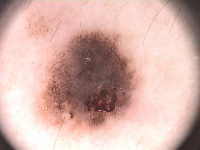</td><td>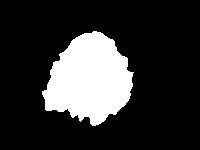</td></tr></table>



In [ ]:
#! wget https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar

In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")


    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

To load the dataset we will use skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [ ]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

The images are of different sizes. Let's resize them to $256 \times 256$ pixels.

[`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize) also automatically normalizes images




In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [ ]:
len(lesions)

200

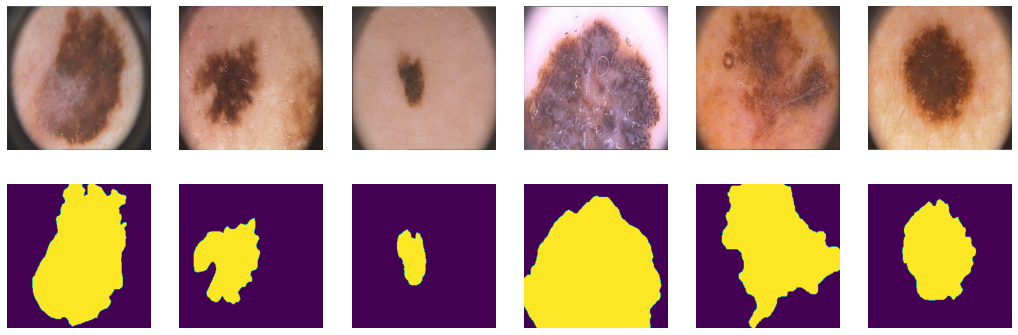

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для валидации и теста

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [ ]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


[](https://)-----------------------------------------------------------------------------------------

# SegNet 

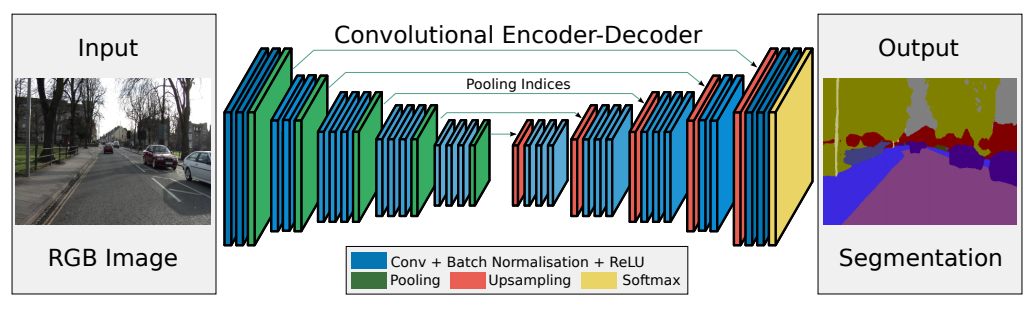

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [ ]:
class SegNet(nn.Module):
    def __init__(self,k=1):

        super().__init__()
        # encoder (downsampling)
        self.enc_conv0  = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32*k, kernel_size=3, padding=1),
            nn.BatchNorm2d(32*k),
            #nn.Dropout2d(p=0.5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        #self.enc_conv0 = 
        #self.pool0 =   # 256 -> 128

        self.enc_conv1 =nn.Sequential(
            nn.Conv2d(in_channels=32*k,out_channels=64*k,kernel_size=3, padding=1),
            nn.BatchNorm2d(64*k),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        #self.enc_conv1 = 
        #self.pool1 =  # 128 -> 64

        self.enc_conv2 =nn.Sequential(
          nn.Conv2d(in_channels=64*k,out_channels=128*k,kernel_size=3, padding=1),
          nn.BatchNorm2d(128*k),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2)
        )
        #self.enc_conv2 = 
        #self.pool2 =  # 64 -> 32

        self.enc_conv3 = nn.Sequential(
          nn.Conv2d(in_channels=128*k,out_channels=256*k,kernel_size=3, padding=1),
          nn.BatchNorm2d(256*k),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2)
        )
        #self.enc_conv3 =
        #self.pool3 =  # 32 -> 16

        # bottleneck 
        self.bottleneck_conv = nn.Conv2d(in_channels=256*k,out_channels=128*k,kernel_size=1)

        # decoder (upsampling)
        self.upsample0 = nn.Sequential(
            nn.UpsamplingBilinear2d(scale_factor=2),# 16 -> 32
            nn.Conv2d(in_channels=128*k, out_channels=64*k, kernel_size=3, padding=1),
            nn.BatchNorm2d(64*k),
            nn.ReLU(),
        )
        #self.upsample0 = # 16 -> 32
        #self.dec_conv0 = 

        self.upsample1 = nn.Sequential(
            nn.UpsamplingBilinear2d(scale_factor=2),# 32 -> 64
            nn.Conv2d(in_channels=64*k, out_channels=32*k, kernel_size=3, padding=1),
            nn.BatchNorm2d(32*k),
            nn.ReLU(),
        )
        #self.upsample1 =  # 32 -> 64
        #self.dec_conv1 = 
        self.upsample2 = nn.Sequential(
            nn.UpsamplingBilinear2d(scale_factor=2),# 64 -> 128
            nn.Conv2d(in_channels=32*k, out_channels=16*k, kernel_size=3, padding=1),
            nn.BatchNorm2d(16*k),
            nn.ReLU(),
        )
        #self.upsample2 =   # 64 -> 128
        #self.dec_conv2 = 

        self.upsample3 = nn.Sequential(
            nn.UpsamplingBilinear2d(scale_factor=2),# 128 -> 256
            nn.Conv2d(in_channels=16*k, out_channels=1, kernel_size=3, padding=1)
        )
        #self.upsample3 =   # 128 -> 256
       # self.dec_conv3 =

    def forward(self, x):
      # encoder
      x = self.enc_conv0(x) #e0
      x = self.enc_conv1(x) #e1
      x = self.enc_conv2(x) #e2
      x = self.enc_conv3(x) #e3

      # bottleneck
      x = self.bottleneck_conv(x) #b

      # decoder
      x = self.upsample0(x) #d0
      x = self.upsample1(x) #d1
      x = self.upsample2(x) #d2
      x = self.upsample3(x) #d2
      # d3 =   # no activation
      return x

## Metric

We will use the following metric

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$



To clarify this we can see on the segmentation:
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


And the intersection will be the following:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # 

### `Loss function`

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [ ]:
def bce_loss(y_real,y_pred):    
    return torch.mean(y_pred-y_real*y_pred+torch.log(1+torch.exp(-y_pred)))

## train function


In [ ]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))
    loss_train=[]
    loss_val=[]
    #test=[]
    scheduler = torch.optim.lr_scheduler.StepLR(opt,step_size=11)

    for epoch in range(epochs):
        
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))
        

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device           

            X_batch=X_batch.to(device)
            Y_batch=Y_batch.to(device)            

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model.forward(X_batch)
            loss = loss_fn(Y_batch,Y_pred)          

            loss.backward() # backward-pass
            opt.step() # update weights

            # calculate loss to show the user                   
            
            avg_loss += loss / len(data_tr)            
           
            
        scheduler.step()
        #test.append([epoch,opt.param_groups[0]['lr']])
        
        loss_train.append(avg_loss)
        toc = time()
        print('loss: %f' % avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        Y_hat = model.forward(X_val.to('cuda')).detach().to('cpu')# detach and put into cpu

        loss_val.append(loss_fn(Y_val,Y_hat)) 

        # #Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            #plt.imshow(np.rollaxis(X_val[k].cpu(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()
    return loss_train, loss_val

## Inference



In [ ]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [ ]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    with torch.no_grad():
      for X_batch, Y_label in data:
          X_batch=X_batch.to(device)
          Y_pred = model(X_batch)
          Y_pred=Y_pred.to('cpu')#
          scores += metric(Y_pred>0.5, Y_label).mean().item()
          #scores += metric(Y_pred>0.5, Y_label.to(device)).mean().item()        

#    torch.cuda.empty_cache()       
    return scores/len(data)

## Train



In [ ]:
model = SegNet().to(device)
import torchsummary
print("Все параметры сети:")
torchsummary.summary(model.cuda(),(3,256,256))

Все параметры сети:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
       BatchNorm2d-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
         MaxPool2d-4         [-1, 32, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]          18,496
       BatchNorm2d-6         [-1, 64, 128, 128]             128
              ReLU-7         [-1, 64, 128, 128]               0
         MaxPool2d-8           [-1, 64, 64, 64]               0
            Conv2d-9          [-1, 128, 64, 64]          73,856
      BatchNorm2d-10          [-1, 128, 64, 64]             256
             ReLU-11          [-1, 128, 64, 64]               0
        MaxPool2d-12          [-1, 128, 32, 32]               0
           Conv2d-13          [-1, 256, 32, 32]         295,168
      BatchNorm2d-1

In [ ]:
SegNet()

SegNet(
  (enc_conv0): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (enc_conv1): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (enc_conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (enc_conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  

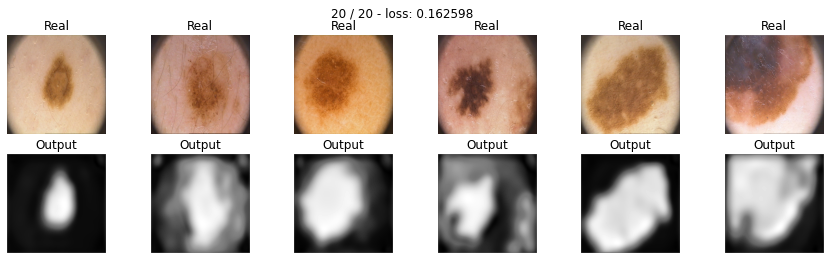

In [ ]:
max_epochs = 20
optim=torch.optim.Adam(model.parameters(),lr=1.0e-3)
SegNet_bce_loss_train, SegNet_bce_loss_val =train(model, optim, bce_loss, max_epochs, data_tr, data_val)

In [ ]:
Scor=[]
Scor.append(('SegNet bce score',score_model(model, iou_pytorch, data_val)))
print(Scor)

[('SegNet bce score', 0.6159999668598175)]


Ответьте себе на вопрос: не переобучается ли моя модель?

График лоса на валидации немножко подскочил вверх, а значит наща модель чуточку переобучилась

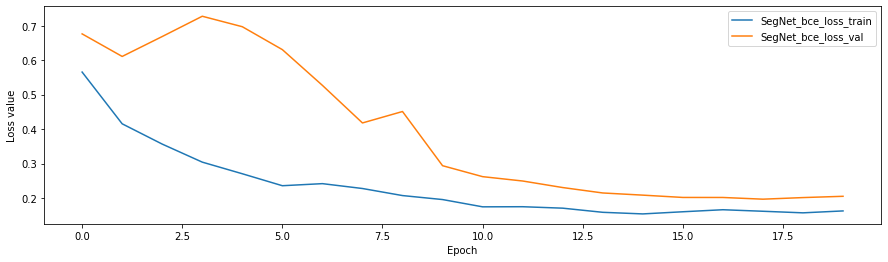

In [ ]:
import matplotlib.pyplot as plt
plt.plot(SegNet_bce_loss_train,label='SegNet_bce_loss_train')
plt.plot(SegNet_bce_loss_val,label='SegNet_bce_loss_val')

plt.xlabel('Epoch')
plt.ylabel('Loss value')

plt.legend()
plt.show()


----------------------------

## Additional loss functions

 В данном разделе будем имплементировать две функции потерь:
 DICE и Focal loss. 



**1. Dice coefficient:** 

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

This function is not differentiable, but it is a necessary property for gradient descent. In this case, we can approximate it with:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$




In [ ]:
def dice_loss(y_real, y_pred):
  y_pred=torch.sigmoid(y_pred)

  numerator=torch.sum(2*y_pred*y_real)
  denominator=torch.sum(y_pred+y_real)
  return 1. - (numerator + 1.) / (denominator + 1.)
  # еденичку добавили что бы не было деления на ноль


Проводим тестирование:

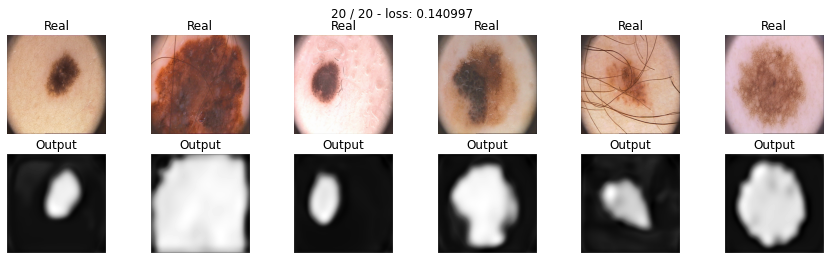

In [ ]:
model = SegNet().to(device)

max_epochs = 20
optimaizer = torch.optim.Adam(model.parameters(),lr=1.0e-3)
SegNet_dice_loss_train, SegNet_dice_loss_val =train(model, optimaizer, dice_loss, max_epochs, data_tr, data_val)

In [ ]:
Scor.append(('SegNet dice score',score_model(model, iou_pytorch, data_val)))
print(Scor[-1])

('SegNet dice score', 0.6319999992847443)


In [ ]:
print(Scor)

[('SegNet bce score', 0.6159999668598175), ('SegNet dice score', 0.6319999992847443)]


[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

The problem with this loss is that it tends to benefit the majority (background) class relative to the minority (front) class. Therefore, weights are usually applied to each class

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Traditionally, the weight $\alpha_i$ is defined as the inverse frequency of the class of that pixel $i$, so that minority class observations weigh more in relation to the majority class.

Another recent addition is a weighted pixel variant, which weights each pixel according to the degree of confidence we have in predicting that pixel.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Let's fix the value $\gamma=2$.

--------------------------------------------------------------------------------


In [ ]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    y_pred =  torch.sigmoid(y_pred)
    y_pred=y_pred.contiguous().view(y_pred.shape[0],-1)
    y_real=y_real.contiguous().view(y_pred.shape[0],-1)

    pt=y_real*y_pred+(1-y_real)*(1-y_pred)
    res=-(1-pt)**gamma*torch.log(pt+eps)
    return res.mean()


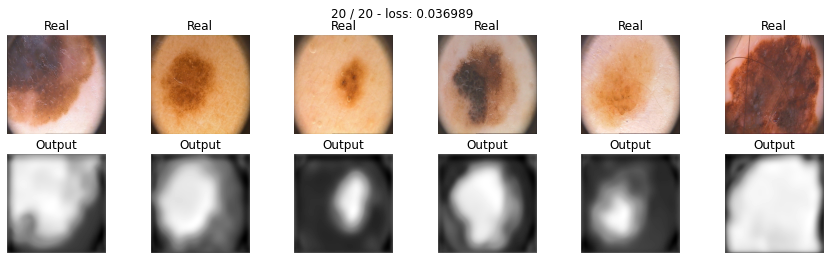

In [ ]:
model = SegNet().to(device)

max_epochs = 20
optimaizer = torch.optim.Adam(model.parameters(),lr=1.0e-3)
SegNet_focal_loss_train,SegNet_focal_loss_val=train(model, optimaizer, focal_loss, max_epochs, data_tr, data_val)

In [ ]:
Scor.append(('SegNet focal score',score_model(model, iou_pytorch, data_val)))
print(Scor[-1])

('SegNet focal score', 0.5099999606609344)



* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)



In [ ]:
def tversky_loss(targets,inputs):
  alpha = 0.5
  beta = 0.5
  smooth=1
  inputs = torch.sigmoid(inputs)       
  
  #flatten label and prediction tensors
  inputs = inputs.view(-1)
  targets = targets.view(-1)
  
  #True Positives, False Positives & False Negatives
  TP = (inputs * targets).sum()    
  FP = ((1-targets) * inputs).sum()
  FN = (targets * (1-inputs)).sum()
  
  Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
  
  return 1 - Tversky

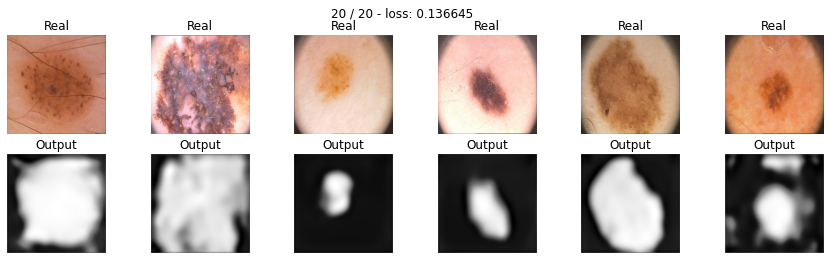

In [ ]:
#model_focal = SegNet().to(device)
model = SegNet().to(device)

max_epochs = 20
optimaizer = torch.optim.Adam(model.parameters(),lr=1e-3)
SegNet_tversky_loss_train,SegNet_tversky_loss_val = train(model, optimaizer, tversky_loss, max_epochs, data_tr, data_val)

In [ ]:
Scor.append(('SegNet tversky score',score_model(model, iou_pytorch, data_val)))
print(Scor[-1])

('SegNet tversky score', 0.6400000154972076)


-----------------------------------------------------------------------------------------

# U-Net

[**U-Net**](https://arxiv.org/abs/1505.04597) 
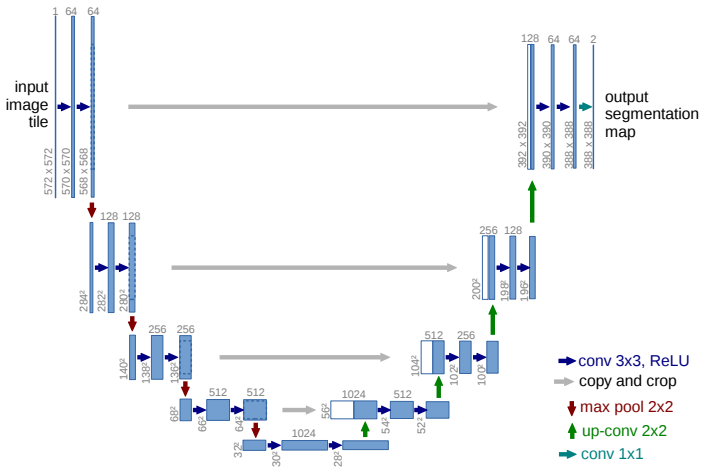



* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [ ]:
class UNet(nn.Module):
    def __init__(self,k=1):

        super().__init__()
        # encoder (downsampling)
        self.enc_conv0  = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32*k, kernel_size=3, padding=1),
            nn.BatchNorm2d(32*k),
            #nn.Dropout2d(p=0.5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        #self.enc_conv0 = 
        #self.pool0 =   # 256 -> 128

        self.enc_conv1 =nn.Sequential(
            nn.Conv2d(in_channels=32*k,out_channels=64*k,kernel_size=3, padding=1),
            nn.BatchNorm2d(64*k),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        #self.enc_conv1 = 
        #self.pool1 =  # 128 -> 64

        self.enc_conv2 =nn.Sequential(
          nn.Conv2d(in_channels=64*k,out_channels=128*k,kernel_size=3, padding=1),
          nn.BatchNorm2d(128*k),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2)
        )
        #self.enc_conv2 = 
        #self.pool2 =  # 64 -> 32

        self.enc_conv3 = nn.Sequential(
          nn.Conv2d(in_channels=128*k,out_channels=256*k,kernel_size=3, padding=1),
          nn.BatchNorm2d(256*k),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2)
        )
        #self.enc_conv3 =
        #self.pool3 =  # 32 -> 16

        # bottleneck 
        self.bottleneck_conv = nn.Conv2d(in_channels=256*k,out_channels=128*k,kernel_size=1)

        # decoder (upsampling)
        self.upsample0 = nn.Sequential(
            nn.UpsamplingBilinear2d(scale_factor=2),# 16 -> 32
            nn.Conv2d(in_channels=256*k+128*k, out_channels=64*k, kernel_size=3, padding=1),
            nn.BatchNorm2d(64*k),
            nn.ReLU(),
        )
        #self.upsample0 = # 16 -> 32
        #self.dec_conv0 = 

        self.upsample1 = nn.Sequential(
            nn.UpsamplingBilinear2d(scale_factor=2),# 32 -> 64
            nn.Conv2d(in_channels=64*k+128*k, out_channels=32*k, kernel_size=3, padding=1),
            nn.BatchNorm2d(32*k),
            nn.ReLU(),
        )
        #self.upsample1 =  # 32 -> 64
        #self.dec_conv1 = 
        self.upsample2 = nn.Sequential(
            nn.UpsamplingBilinear2d(scale_factor=2),# 64 -> 128
            nn.Conv2d(in_channels=32*k+64*k, out_channels=16*k, kernel_size=3, padding=1),
            nn.BatchNorm2d(16*k),
            nn.ReLU(),
        )
        #self.upsample2 =   # 64 -> 128
        #self.dec_conv2 = 

        self.upsample3 = nn.Sequential(
            nn.UpsamplingBilinear2d(scale_factor=2),# 128 -> 256
            nn.Conv2d(in_channels=16*k+32*k, out_channels=1, kernel_size=3, padding=1)
        )
        #self.upsample3 =   # 128 -> 256
       # self.dec_conv3 =

    def forward(self, x):
      # encoder
      e0 = self.enc_conv0(x) #e0
      e1 = self.enc_conv1(e0) #e1
      e2 = self.enc_conv2(e1) #e2
      e3 = self.enc_conv3(e2) #e3

      # bottleneck
      b = self.bottleneck_conv(e3) #b

      x = torch.cat([b, e3],dim=1)
      # decoder      
      x = self.upsample0(x) #d0

      x = torch.cat([x, e2],dim=1)
      x = self.upsample1(x) #d1

      x = torch.cat([x, e1],dim=1)
      x = self.upsample2(x) #d2

      x = torch.cat([x, e0],dim=1)
      x = self.upsample3(x) #d2
      # d3 =   # no activation
      return x

In [ ]:
model = UNet().to(device)
import torchsummary
torchsummary.summary(model.cuda(),(3,256,256))

Все параметры сети:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
       BatchNorm2d-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
         MaxPool2d-4         [-1, 32, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]          18,496
       BatchNorm2d-6         [-1, 64, 128, 128]             128
              ReLU-7         [-1, 64, 128, 128]               0
         MaxPool2d-8           [-1, 64, 64, 64]               0
            Conv2d-9          [-1, 128, 64, 64]          73,856
      BatchNorm2d-10          [-1, 128, 64, 64]             256
             ReLU-11          [-1, 128, 64, 64]               0
        MaxPool2d-12          [-1, 128, 32, 32]               0
           Conv2d-13          [-1, 256, 32, 32]         295,168
      BatchNorm2d-1

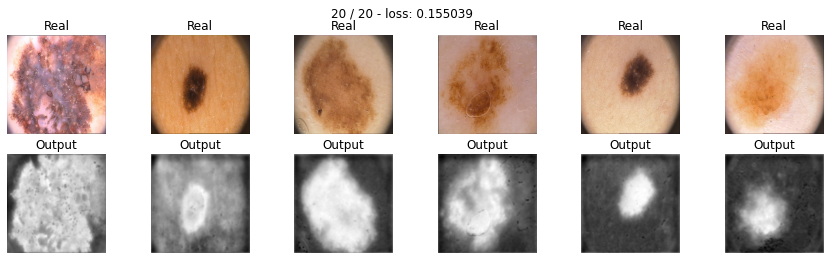

In [ ]:
max_epochs = 20
optimaizer = torch.optim.Adam(model.parameters(),lr=1.0e-3)
UNet_bce_loss_train,UNet_bce_loss_val=train(model, optimaizer, bce_loss, max_epochs, data_tr, data_val)

In [ ]:
Scor.append(('UNet bce score',score_model(model, iou_pytorch, data_val)))
print(Scor[-1])

('UNet bce score', 0.6319999992847443)


In [ ]:
#####NEW

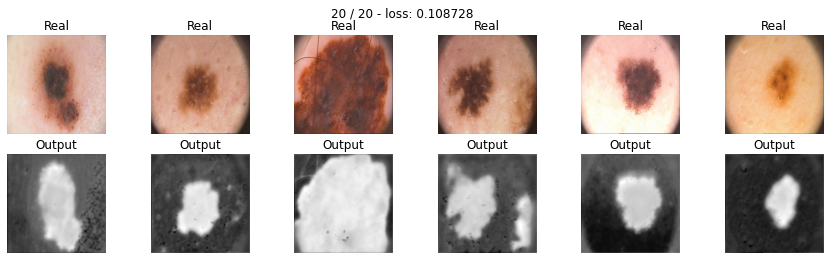

('UNet dice_loss score', 0.6899999380111694)


In [ ]:
model = UNet().to(device)
max_epochs = 20
optimaizer = torch.optim.Adam(model.parameters(),lr=1.0e-3)
UNet_dice_loss_train,UNet_dice_loss_val=train(model, optimaizer, dice_loss, max_epochs, data_tr, data_val)
Scor.append(('UNet dice_loss score',score_model(model, iou_pytorch, data_val)))
print(Scor[-1])

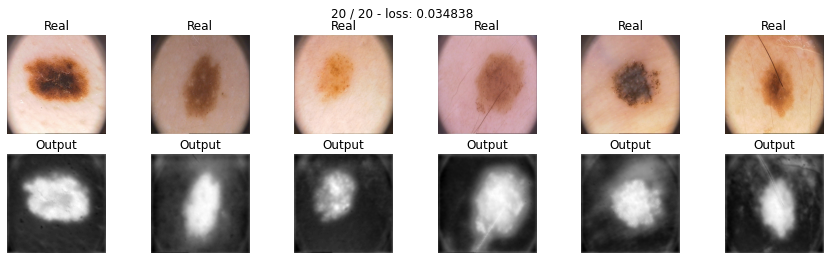

('UNet focal_loss score', 0.6020000278949738)


In [ ]:
model = UNet().to(device)
max_epochs = 20
optimaizer = torch.optim.Adam(model.parameters(),lr=1.0e-3)
UNet_focal_loss_train,UNet_focal_loss_val=train(model, optimaizer, focal_loss, max_epochs, data_tr, data_val)
Scor.append(('UNet focal_loss score',score_model(model, iou_pytorch, data_val)))
print(Scor[-1])

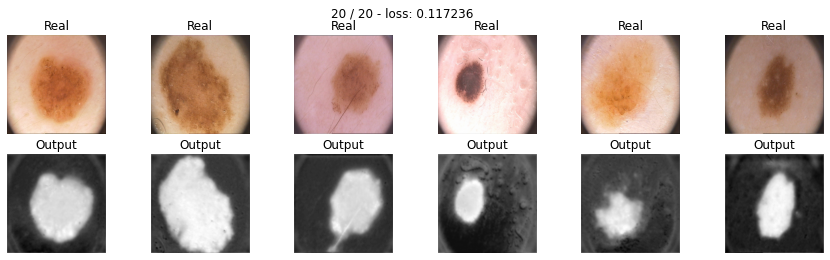

('UNet tversky_loss score', 0.6899999976158142)


In [ ]:
model = UNet().to(device)
max_epochs = 20
optimaizer = torch.optim.Adam(model.parameters(),lr=1.0e-3)
UNet_focal_loss_train,UNet_focal_loss_val=train(model, optimaizer, tversky_loss, max_epochs, data_tr, data_val)
Scor.append(('UNet tversky_loss score',score_model(model, iou_pytorch, data_val)))
print(Scor[-1])

# Unet2


 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Replace

max-pooling $\longrightarrow$ convolutions with stride=2 and

upsampling $\longrightarrow$ transpose-convolutions with stride=2.



In [ ]:
class UNet2(nn.Module):
    def __init__(self,k=1):

        super().__init__()
        # encoder (downsampling)
        self.enc_conv0  = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32*k, kernel_size=3, padding=1),
            nn.BatchNorm2d(32*k),
            #nn.Dropout2d(p=0.5),
            nn.ReLU(),
            #nn.MaxPool2d(kernel_size=(3,2),padding=1)
            #nn.MaxPool2d(3, 2, padding=1)
            #nn.MaxPool2d(kernel_size=3, stride=2, padding=1) 
            nn.Conv2d(in_channels=32*k, out_channels=32*k, kernel_size=3, stride=2,padding=1),
        )
        #self.enc_conv0 = 
        #self.pool0 =   # 256 -> 128

        self.enc_conv1 =nn.Sequential(
            nn.Conv2d(in_channels=32*k,out_channels=64*k,kernel_size=3, padding=1),
            nn.BatchNorm2d(64*k),
            nn.ReLU(),
            #nn.MaxPool2d(kernel_size=3, stride=2, padding=1) 
            nn.Conv2d(in_channels=64*k, out_channels=64*k, kernel_size=3, stride=2,padding=1),
        )
        #self.enc_conv1 = 
        #self.pool1 =  # 128 -> 64

        self.enc_conv2 =nn.Sequential(
          nn.Conv2d(in_channels=64*k,out_channels=128*k,kernel_size=3, padding=1),
          nn.BatchNorm2d(128*k),
          nn.ReLU(),
          #nn.MaxPool2d(kernel_size=3, stride=2, padding=1) 
          nn.Conv2d(in_channels=128*k, out_channels=128*k, kernel_size=3, stride=2,padding=1),
        )
        #self.enc_conv2 = 
        #self.pool2 =  # 64 -> 32

        self.enc_conv3 = nn.Sequential(
          nn.Conv2d(in_channels=128*k,out_channels=256*k,kernel_size=3, padding=1),
          nn.BatchNorm2d(256*k),
          nn.ReLU(),
          #nn.MaxPool2d(kernel_size=3, stride=2, padding=1) 
          nn.Conv2d(in_channels=256*k, out_channels=256*k, kernel_size=3, stride=2,padding=1),
        )
        #self.enc_conv3 =
        #self.pool3 =  # 32 -> 16

        # bottleneck 
        self.bottleneck_conv = nn.Conv2d(in_channels=256*k,out_channels=128*k,kernel_size=1)

        # decoder (upsampling)
        self.upsample0 = nn.Sequential(                  
            #nn.UpsamplingBilinear2d(scale_factor=2),# 16 -> 32            
            nn.ConvTranspose2d(in_channels=256*k+128*k, out_channels=256*k+128*k,kernel_size=2,stride=2),
            nn.Conv2d(in_channels=256*k+128*k, out_channels=64*k, kernel_size=3, padding=1),
            nn.BatchNorm2d(64*k),
            nn.ReLU(),
        )
        #self.upsample0 = # 16 -> 32
        #self.dec_conv0 = 

        self.upsample1 = nn.Sequential(
            #nn.UpsamplingBilinear2d(scale_factor=2),# 32 -> 64
            nn.ConvTranspose2d(in_channels=64*k+128*k, out_channels=64*k+128*k,kernel_size=2,stride=2),
            nn.Conv2d(in_channels=64*k+128*k, out_channels=32*k, kernel_size=3, padding=1),
            nn.BatchNorm2d(32*k),
            nn.ReLU(),
        )
        #self.upsample1 =  # 32 -> 64
        #self.dec_conv1 = 
        self.upsample2 = nn.Sequential(
            #nn.UpsamplingBilinear2d(scale_factor=2),# 64 -> 128
            nn.ConvTranspose2d(in_channels=32*k+64*k, out_channels=32*k+64*k,kernel_size=2,stride=2),
            nn.Conv2d(in_channels=32*k+64*k, out_channels=16*k, kernel_size=3, padding=1),
            nn.BatchNorm2d(16*k),
            nn.ReLU(),
        )
        #self.upsample2 =   # 64 -> 128
        #self.dec_conv2 = 

        self.upsample3 = nn.Sequential(
            #nn.UpsamplingBilinear2d(scale_factor=2),# 128 -> 256
            nn.ConvTranspose2d(in_channels=16*k+32*k, out_channels=16*k+32*k,kernel_size=2,stride=2),
            nn.Conv2d(in_channels=16*k+32*k, out_channels=1, kernel_size=3, padding=1)
        )
        #self.upsample3 =   # 128 -> 256
       # self.dec_conv3 =

    def forward(self, x):
      # encoder
      e0 = self.enc_conv0(x) #e0
      e1 = self.enc_conv1(e0) #e1
      e2 = self.enc_conv2(e1) #e2
      e3 = self.enc_conv3(e2) #e3

      # bottleneck
      b = self.bottleneck_conv(e3) #b

      x = torch.cat([b, e3],dim=1)
      # decoder      
      x = self.upsample0(x) #d0

      x = torch.cat([x, e2],dim=1)
      x = self.upsample1(x) #d1

      x = torch.cat([x, e1],dim=1)
      x = self.upsample2(x) #d2

      x = torch.cat([x, e0],dim=1)
      x = self.upsample3(x) #d2
      # d3 =   # no activation
      return x

In [ ]:
model = UNet2().to(device)
import torchsummary
print("Все параметры сети:")
torchsummary.summary(model.cuda(),(3,256,256))

Все параметры сети:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
       BatchNorm2d-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
            Conv2d-4         [-1, 32, 128, 128]           9,248
            Conv2d-5         [-1, 64, 128, 128]          18,496
       BatchNorm2d-6         [-1, 64, 128, 128]             128
              ReLU-7         [-1, 64, 128, 128]               0
            Conv2d-8           [-1, 64, 64, 64]          36,928
            Conv2d-9          [-1, 128, 64, 64]          73,856
      BatchNorm2d-10          [-1, 128, 64, 64]             256
             ReLU-11          [-1, 128, 64, 64]               0
           Conv2d-12          [-1, 128, 32, 32]         147,584
           Conv2d-13          [-1, 256, 32, 32]         295,168
      BatchNorm2d-1

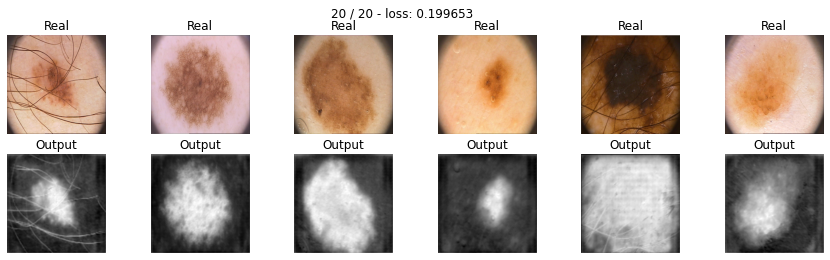

In [ ]:
optimaizer = torch.optim.Adam(model.parameters(),lr=1.0e-3)
UNet2_bce_loss_train,UNet2_bce_loss_val=train(model, optimaizer, bce_loss, max_epochs, data_tr, data_val)


In [ ]:
Scor.append(('UNet2 bce score',score_model(model, iou_pytorch, data_val)))
print(Scor[-1])

('UNet2 bce score', 0.5519999861717224)


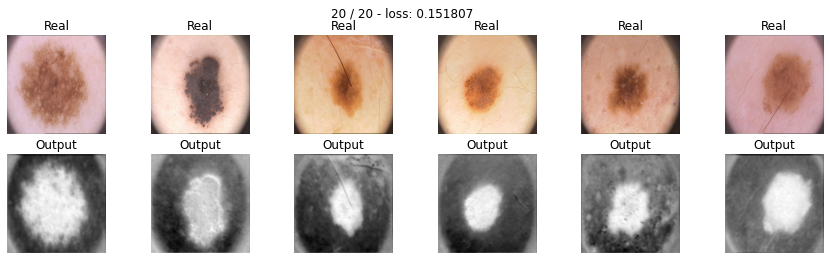

('UNet2 tversky_loss score', 0.4699999988079071)


In [ ]:
model = UNet2().to(device)
max_epochs = 20
optimaizer = torch.optim.Adam(model.parameters(),lr=1.0e-3)
UNet2_bce_loss_train,UNet2_bce_loss_val=train(model, optimaizer, dice_loss, max_epochs, data_tr, data_val)
Scor.append(('UNet2 dice_loss score',score_model(model, iou_pytorch, data_val)))
print(Scor[-1])

model = UNet2().to(device)
max_epochs = 20
optimaizer = torch.optim.Adam(model.parameters(),lr=1.0e-3)
UNet2_focal_loss_train,UNet2_focal_loss_val=train(model, optimaizer, focal_loss, max_epochs, data_tr, data_val)
Scor.append(('UNet2 focal_loss score',score_model(model, iou_pytorch, data_val)))
print(Scor[-1])

model = UNet2().to(device)
max_epochs = 20
optimaizer = torch.optim.Adam(model.parameters(),lr=1.0e-3)
UNet2_tversky_loss_train,UNet2_tversky_loss_val=train(model, optimaizer, tversky_loss, max_epochs, data_tr, data_val)
Scor.append(('UNet2 tversky_loss score',score_model(model, iou_pytorch, data_val)))
print(Scor[-1])

# conclusions


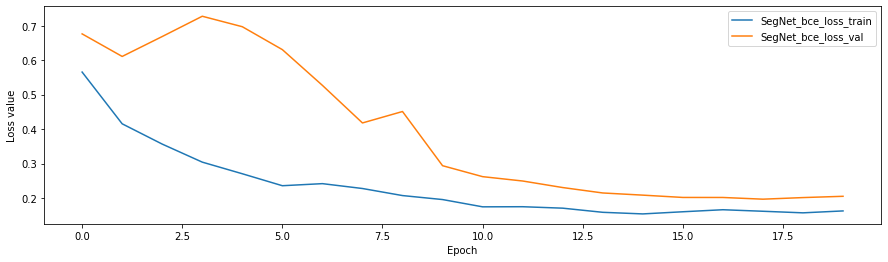

In [ ]:
import matplotlib.pyplot as plt
plt.plot(SegNet_bce_loss_train,label='SegNet_bce_loss_train')
plt.plot(SegNet_bce_loss_val,label='SegNet_bce_loss_val')

plt.xlabel('Epoch')
plt.ylabel('Loss value')

plt.legend()
plt.show()


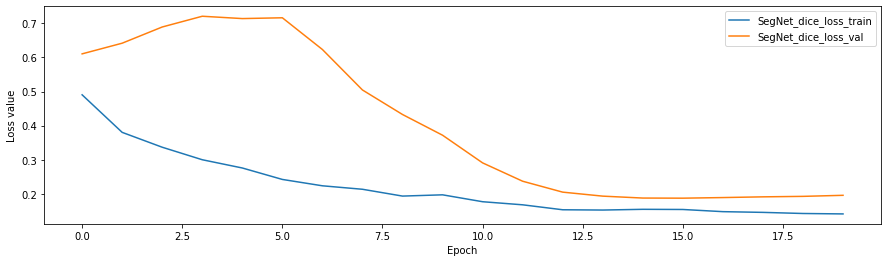

In [ ]:
import matplotlib.pyplot as plt
plt.plot(SegNet_dice_loss_train,label='SegNet_dice_loss_train')
plt.plot(SegNet_dice_loss_val,label='SegNet_dice_loss_val')

plt.xlabel('Epoch')
plt.ylabel('Loss value')

plt.legend()
plt.show()


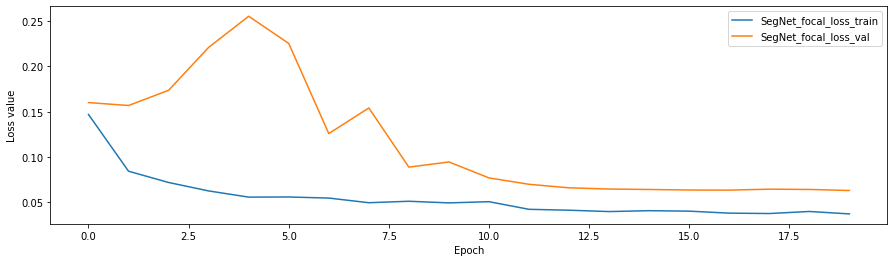

In [ ]:
import matplotlib.pyplot as plt
plt.plot(SegNet_focal_loss_train,label='SegNet_focal_loss_train')
plt.plot(SegNet_focal_loss_val,label='SegNet_focal_loss_val')

plt.xlabel('Epoch')
plt.ylabel('Loss value')

plt.legend()
plt.show()


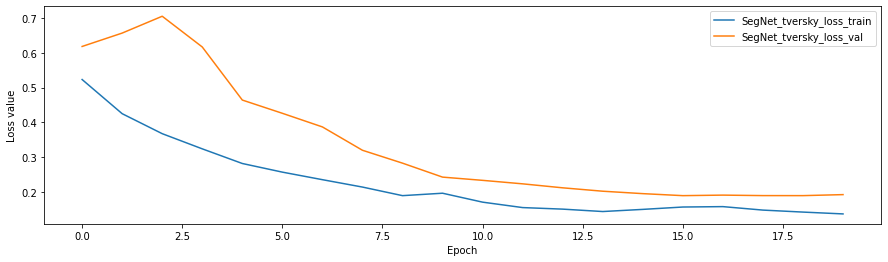

In [ ]:
import matplotlib.pyplot as plt
plt.plot(SegNet_tversky_loss_train,label='SegNet_tversky_loss_train')
plt.plot(SegNet_tversky_loss_val,label='SegNet_tversky_loss_val')

plt.xlabel('Epoch')
plt.ylabel('Loss value')

plt.legend()
plt.show()


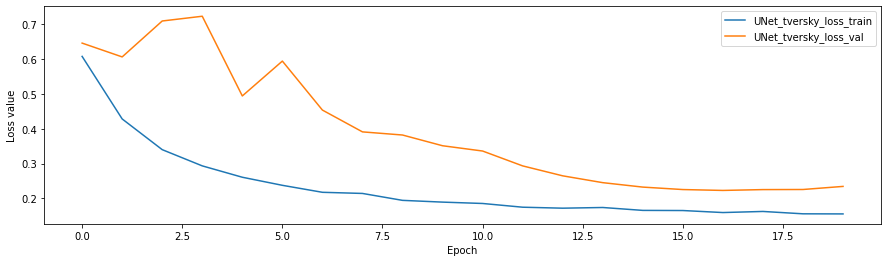

In [ ]:
import matplotlib.pyplot as plt
plt.plot(UNet_bce_loss_train,label='UNet_tversky_loss_train')
plt.plot(UNet_bce_loss_val,label='UNet_tversky_loss_val')

plt.xlabel('Epoch')
plt.ylabel('Loss value')

plt.legend()
plt.show()


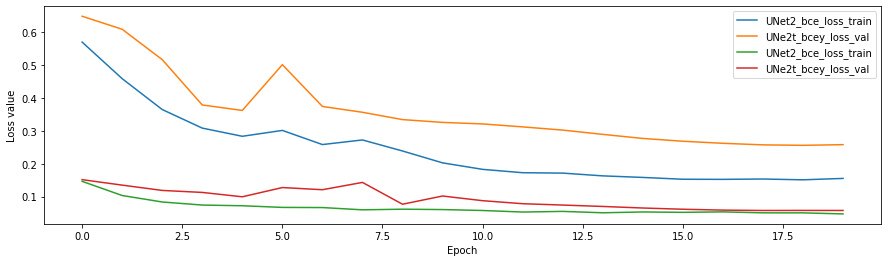

In [ ]:
import matplotlib.pyplot as plt
plt.plot(UNet2_bce_loss_train,label='UNet2_bce_loss_train')
plt.plot(UNet2_bce_loss_val,label='UNe2t_bcey_loss_val')

plt.plot(UNet2_focal_loss_train,label='UNet2_bce_loss_train')
plt.plot(UNet2_focal_loss_val,label='UNe2t_bcey_loss_val')

plt.xlabel('Epoch')
plt.ylabel('Loss value')

plt.legend()
plt.show()


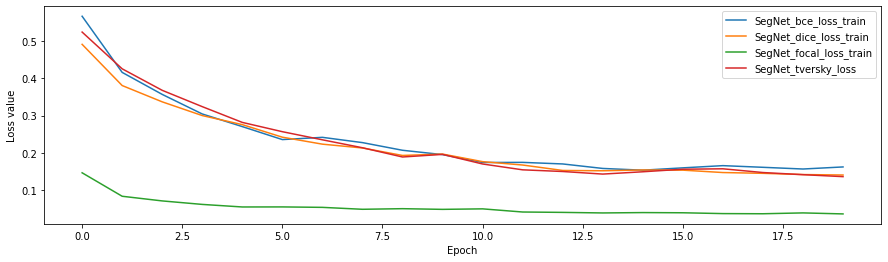

In [ ]:
import matplotlib.pyplot as plt
plt.plot(SegNet_bce_loss_train,label='SegNet_bce_loss_train')
plt.plot(SegNet_dice_loss_train,label='SegNet_dice_loss_train')
plt.plot(SegNet_focal_loss_train,label='SegNet_focal_loss_train')
plt.plot(SegNet_tversky_loss_train,label='SegNet_tversky_loss')

plt.xlabel('Epoch')
plt.ylabel('Loss value')

plt.legend()
plt.show()


In [ ]:
Scor

[('SegNet bce score', 0.6159999668598175),
 ('SegNet dice score', 0.6319999992847443),
 ('SegNet focal score', 0.5099999606609344),
 ('SegNet tversky score', 0.6400000154972076),
 ('UNet bce score', 0.6319999992847443),
 ('UNet dice_loss score', 0.6899999380111694),
 ('UNet focal_loss score', 0.6020000278949738),
 ('UNet tversky_loss score', 0.6899999976158142),
 ('UNet2 bce score', 0.5519999861717224),
 ('UNet2 dice_loss score', 0.534000039100647),
 ('UNet2 focal_loss score', 0.44200001657009125),
 ('UNet2 tversky_loss score', 0.4699999988079071)]